In [4]:
import datetime
import covsirphy as cs
#%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
path = '/Users/jorrimprins/Google Drive/MSc Computational Science/Introduction to Computational Science/Project'
data_loader = cs.DataLoader(path+"covsirdata.csv")
#S I R data, population data and regulations data
jhu_data = data_loader.jhu(verbose=False)
population_data = data_loader.population(verbose=False)
oxcgrt_data = data_loader.oxcgrt(verbose=True)
#Testing_policy, Contact_tracing
#School_closing, Gatherings_restrictions
pd.set_option('display.max_columns', None)

## Plot new cases
-Calculate new cases from cumulative cases and plot for all countries

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


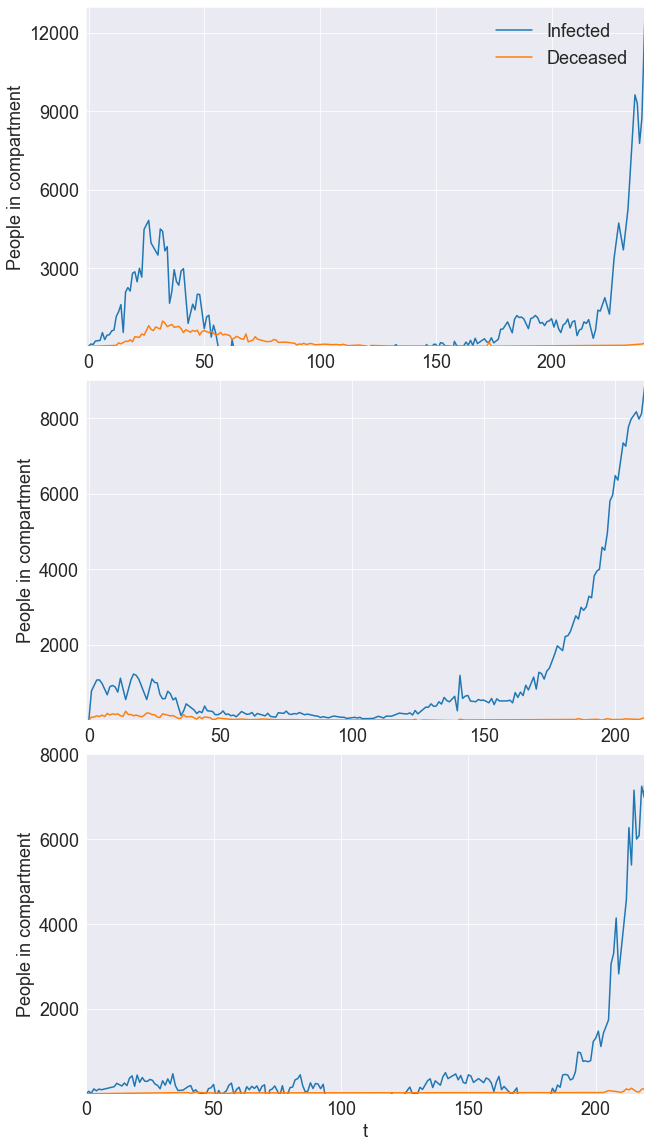

In [36]:
df_NL = jhu_data.subset('Netherlands')
df_IT = jhu_data.subset('Italy')
df_PL = jhu_data.subset('Poland')
datalist = [df_IT, df_NL, df_PL]

sns.set_style("darkgrid")
fig, axs = plt.subplots(3, 1, figsize=(10,20), sharex=False)
#fig.tight_layout()
plt.subplots_adjust(hspace=0.1)

for data in datalist:
    data['new_Infected'] = np.zeros(len(data))
    data['new_Fatal'] = np.zeros(len(data))
    #data['new_Recovered'] = np.zeros(len(data))
    for j in range(1,len(data)):
        data['new_Infected'].iloc[j] = data['Infected'].iloc[j] - data['Infected'].iloc[j-1]
        data['new_Fatal'].iloc[j] = data['Fatal'].iloc[j] - data['Fatal'].iloc[j-1]
        #data['new_Recovered'].iloc[j] = data['Recovered'].iloc[j] - data['Recovered'].iloc[j-1]
        
for i in range(len(datalist)):
    axs[i].plot(datalist[i]['new_Infected'],label='Infected')
    axs[i].plot(datalist[i]['new_Fatal'],label='Deceased')
    #axs[i].plot(datalist[i]['new_Recovered'],label='Recovered')
    axs[i].set_xticks(np.round(np.arange(0,210,50),0))
    axs[i].set_xticklabels(np.round(np.arange(0,210,50),0),fontsize=18)
    axs[i].set_ylabel('People in compartment',fontsize=18)

axs[1].set_xlim([-1,211])
axs[0].set_xlim([-1,240])
axs[2].set_xlim([0,219])

axs[1].set_yticks(np.round(np.arange(2000,8100,2000),0))
axs[1].set_yticklabels(np.round(np.arange(2000,8100,2000),0),fontsize=18)
axs[1].set_ylim([0,9000])
axs[0].set_yticks(np.round(np.arange(3000,12100,3000),0))
axs[0].set_yticklabels(np.round(np.arange(3000,12100,3000),0),fontsize=18)
axs[0].set_ylim([0,13000])
axs[2].set_yticks(np.round(np.arange(2000,8100,2000),0))
axs[2].set_yticklabels(np.round(np.arange(2000,8100,2000),0),fontsize=18)
axs[2].set_ylim([0,8000])

axs[0].legend(fontsize=18)
axs[2].set_xlabel('t', fontsize=18)

fig.savefig('base_dynamics.pdf',dpi=100)

## NL: Estimation and scenarios

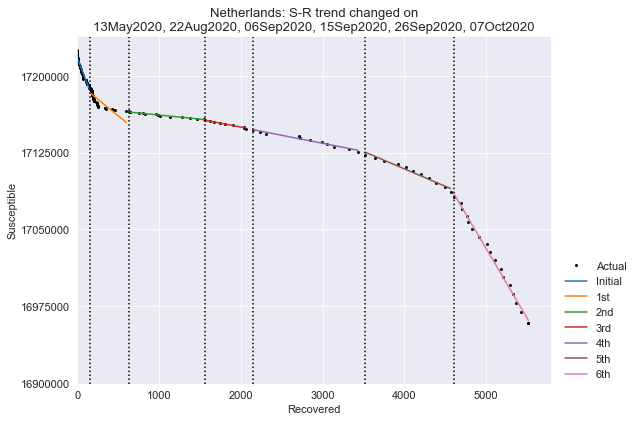


<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
	 6th phase (07Oct2020 - 24Oct2020): finished 1756 trials in 1 min  0 sec
Completed optimization. Total: 2 min  5 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min  6 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min  5 sec


In [6]:
NL = cs.Scenario(jhu_data, population_data, country="Netherlands", province=None)
NL.trend()
NL.estimate(cs.SIRD)
NL.retrospective("01Sep2020", model=cs.SIRD, control="Main", target="Retro")

In [7]:
NL.clear()
NL.add(days=30,name="Main")
NL.add(end_date="01Apr2022", name="Main")
impact = NL.summary().rho[1]/NL.summary().rho[0]
rho = NL.get("rho", name="Main", phase=NL.summary().loc["Main"].index[-1])
rho_new = rho*impact
NL.clear(name="Lockdown")
NL.add(name="Lockdown", days=30, rho=rho)
NL.add(name="Lockdown", end_date="01Apr2022", rho=rho_new)
rho_semi = rho_new*2
NL.clear(name="Semi-LD")
NL.add(name="Semi-LD", days=30, rho=rho) #nu ingaan of pas over maand
NL.add(name="Semi-LD", end_date="01Apr2022", rho=rho_semi)
sigma_med = NL.get("sigma", name="Main", phase=NL.summary().loc["Main"].index[-1])*2
rho_med = rho #of x 2???
NL.clear(name="Medicine")
NL.add(name="Medicine", days=30, rho=rho_med,sigma=sigma_med)
NL.add(name="Medicine", end_date="01Apr2022", rho=rho_med,sigma=sigma_med)
NL.clear(name="Retro")
NL.add(days=30,name="Retro")
NL.add(end_date="01Apr2022", name="Retro")
NL.clear(name="Main")
NL.add(days=30,name="Main")
NL.add(end_date="01Apr2022", name="Main")

#Target rho's
kappa_current = NL.get("kappa", name="Main", phase=NL.summary().loc["Main"].index[-1])
sigma_current = NL.get("sigma", name="Main", phase=NL.summary().loc["Main"].index[-1])
rho_target = kappa_current+sigma_current
kappa_med = NL.get("kappa", name="Main", phase=NL.summary().loc["Medicine"].index[-1])
sigma_med = NL.get("sigma", name="Main", phase=NL.summary().loc["Medicine"].index[-1])
rho_med_target = kappa_med+sigma_med
NL.clear(name="Target")
NL.add(name="Target", end_date="01Apr2022", rho=rho_target)

#Compare scenarios
#_ = NL.history(target="Infected") #Target = Infected or history_rate="main"
#_ = NL.history(target="rho") #Target = Infected or history_rate="main"
NL.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2022,Infected on 02Apr2022,Fatal on 02Apr2022,3rd_Rt,4th_Rt,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt
Main,16193585,05Jun2021,17231619,14411871,851533,7.08,17.23,15.90,29.93,92.53,92.53,92.53
Retro,3674098,02Apr2022,4075059,3674098,24343,11.63,11.63,11.63,-,-,-,-
Lockdown,2139425,02Apr2022,2460658,2139425,99819,7.08,17.23,15.90,29.93,92.53,92.53,5.71
Semi-LD,5337713,02Apr2022,5909185,5337713,175107,7.08,17.23,15.90,29.93,92.53,92.53,11.42
Medicine,15644124,24May2021,17231612,12736486,800692,7.08,17.23,15.90,29.93,92.53,54.46,54.46
Target,286626,25Oct2020,361870,285403,26177,7.08,17.23,15.90,29.93,92.53,1,-


## IT: Estimation and scenarios

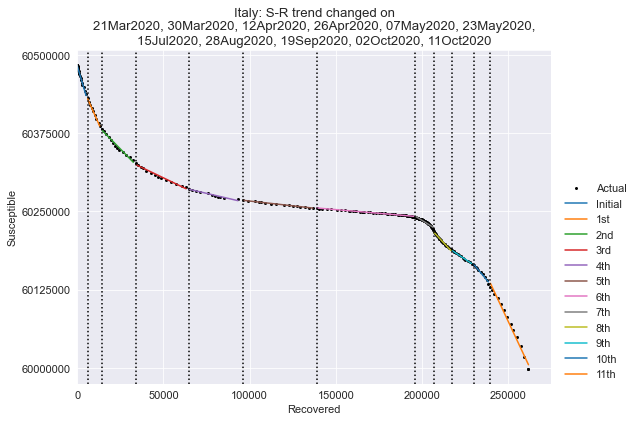


<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
	11th phase (11Oct2020 - 24Oct2020): finished  174 trials in 0 min  5 sec
Completed optimization. Total: 1 min 16 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min 16 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min  5 sec


In [8]:
IT = cs.Scenario(jhu_data, population_data, country="Italy", province=None)
IT.trend()
IT.estimate(cs.SIRD)
IT.retrospective("01Sep2020", model=cs.SIRD, control="Main", target="Retro")

In [9]:
IT.clear()
IT.add(days=30,name="Main")
IT.add(end_date="01Apr2022", name="Main")
impact = IT.summary().rho[3]/IT.summary().rho[0]
rho = IT.get("rho", name="Main", phase=IT.summary().loc["Main"].index[-1])
rho_new = rho*impact
IT.clear(name="Lockdown")
IT.add(name="Lockdown", days=30, rho=rho)
IT.add(name="Lockdown", end_date="01Apr2022", rho=rho_new)
rho_semi = rho_new*2
IT.clear(name="Semi-LD")
IT.add(name="Semi-LD", days=30, rho=rho) #nu ingaan of pas over maand
IT.add(name="Semi-LD", end_date="01Apr2022", rho=rho_semi)
sigma_med = IT.get("sigma", name="Main", phase=IT.summary().loc["Main"].index[-1])*2
rho_med = rho #of x 2???
IT.clear(name="Medicine")
IT.add(name="Medicine", days=30, rho=rho_med,sigma=sigma_med)
IT.add(name="Medicine", end_date="01Apr2022", rho=rho_med,sigma=sigma_med)
IT.clear(name="Retro")
IT.add(days=30,name="Retro")
IT.add(end_date="01Apr2022", name="Retro")
IT.clear(name="Main")
IT.add(days=30,name="Main")
IT.add(end_date="01Apr2022", name="Main")

#Target rho's
kappa_current = IT.get("kappa", name="Main", phase=IT.summary().loc["Main"].index[-1])
sigma_current = IT.get("sigma", name="Main", phase=IT.summary().loc["Main"].index[-1])
rho_target = kappa_current+sigma_current
kappa_med = IT.get("kappa", name="Main", phase=IT.summary().loc["Medicine"].index[-1])
sigma_med = IT.get("sigma", name="Main", phase=IT.summary().loc["Medicine"].index[-1])
rho_med_target = kappa_med+sigma_med
IT.clear(name="Target")
IT.add(name="Target", end_date="01Apr2022", rho=rho_target)

#Compare scenarios
# _ = IT.history(target="Infected") #Target = Infected or history_rate="main"
# _ = IT.history(target="rho") #Target = Infected or history_rate="main"
IT.describe()

#NL.summary()

,max(Infected),argmax(Infected),Confirmed on 02Apr2022,Infected on 02Apr2022,Fatal on 02Apr2022,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt
Main,29033851,12Feb2021,60082322,65924,2038700,3.00,1.88,2.85,5.07,5.07,5.07
Retro,28160609,11Apr2021,59963366,1112765,832546,4.86,4.86,4.86,-,-,-
Lockdown,1401276,24Nov2020,4174911,61735,164794,3.00,1.88,2.85,5.07,5.07,0.65
Semi-LD,2734562,15Sep2021,21464090,2070178,677013,3.00,1.88,2.85,5.07,5.07,1.3
Medicine,14772189,25Feb2021,54573398,2284,962169,3.00,1.88,2.85,5.07,2.58,2.58
Target,198953,25Oct2020,2053399,165402,90205,3.00,1.88,2.85,5.07,1,-


## PL: Estimation and scenarios

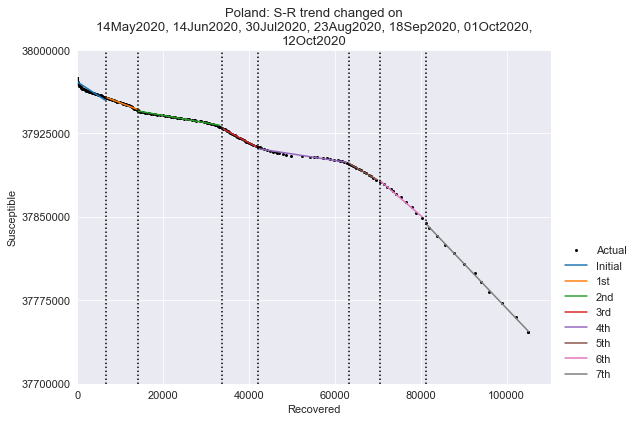


<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
	 7th phase (12Oct2020 - 24Oct2020): finished 1761 trials in 1 min  0 sec
Completed optimization. Total: 2 min  5 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min 11 sec

<SIR-D model: parameter estimation>
Running optimization with 8 CPUs...
Completed optimization. Total: 1 min  5 sec


In [10]:
PL = cs.Scenario(jhu_data, population_data, country="Poland", province=None)
PL.trend()
PL.estimate(cs.SIRD)
PL.retrospective("01Sep2020", model=cs.SIRD, control="Main", target="Retro")

In [11]:
PL.clear()
PL.add(days=30,name="Main")
PL.add(end_date="01Apr2022", name="Main")
impact = PL.summary().rho[1]/PL.summary().rho[0]
rho = PL.get("rho", name="Main", phase=PL.summary().loc["Main"].index[-1])
rho_new = rho*impact
PL.clear(name="Lockdown")
PL.add(name="Lockdown", days=30, rho=rho)
PL.add(name="Lockdown", end_date="01Apr2022", rho=rho_new)
rho_semi = rho_new*2
PL.clear(name="Semi-LD")
PL.add(name="Semi-LD", days=30, rho=rho) #nu ingaan of pas over maand
PL.add(name="Semi-LD", end_date="01Apr2022", rho=rho_semi)
sigma_med = PL.get("sigma", name="Main", phase=PL.summary().loc["Main"].index[-1])*2
rho_med = rho #of x 2???
PL.clear(name="Medicine")
PL.add(name="Medicine", days=30, rho=rho_med,sigma=sigma_med)
PL.add(name="Medicine", end_date="01Apr2022", rho=rho_med,sigma=sigma_med)
PL.clear(name="Retro")
PL.add(days=30,name="Retro")
PL.add(end_date="01Apr2022", name="Retro")
PL.clear(name="Main")
PL.add(days=30,name="Main")
PL.add(end_date="01Apr2022", name="Main")

#Target rho's
kappa_current = PL.get("kappa", name="Main", phase=PL.summary().loc["Main"].index[-1])
sigma_current = PL.get("sigma", name="Main", phase=PL.summary().loc["Main"].index[-1])
rho_target = kappa_current+sigma_current
kappa_med = PL.get("kappa", name="Main", phase=PL.summary().loc["Medicine"].index[-1])
sigma_med = PL.get("sigma", name="Main", phase=PL.summary().loc["Medicine"].index[-1])
rho_med_target = kappa_med+sigma_med
PL.clear(name="Target")
PL.add(name="Target", end_date="01Apr2022", rho=rho_target)

#Compare scenarios
# _ = PL.history(target="Infected") #Target = Infected or history_rate="main"
# _ = PL.history(target="rho") #Target = Infected or history_rate="main"
PL.describe()

#NL.summary()

,max(Infected),argmax(Infected),Confirmed on 02Apr2022,Infected on 02Apr2022,Fatal on 02Apr2022,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt
Main,15099043,12Jan2021,37187923,164,1642459,0.44,2.12,2.80,3.95,3.95,3.95
Retro,1188017,02Apr2022,8939031,1188017,164113,1.31,1.31,1.31,-,-,-
Lockdown,3248830,09Mar2021,23116826,80023,1017198,0.44,2.12,2.80,3.95,3.95,1.48
Semi-LD,11389182,27Jan2021,35655481,787,1574720,0.44,2.12,2.80,3.95,3.95,2.96
Medicine,5943753,26Jan2021,29961925,9,678724,0.44,2.12,2.80,3.95,2.02,2.02
Target,140851,25Oct2020,2022666,85810,84897,0.44,2.12,2.80,3.95,1,-


## Plots for infected and $\rho$

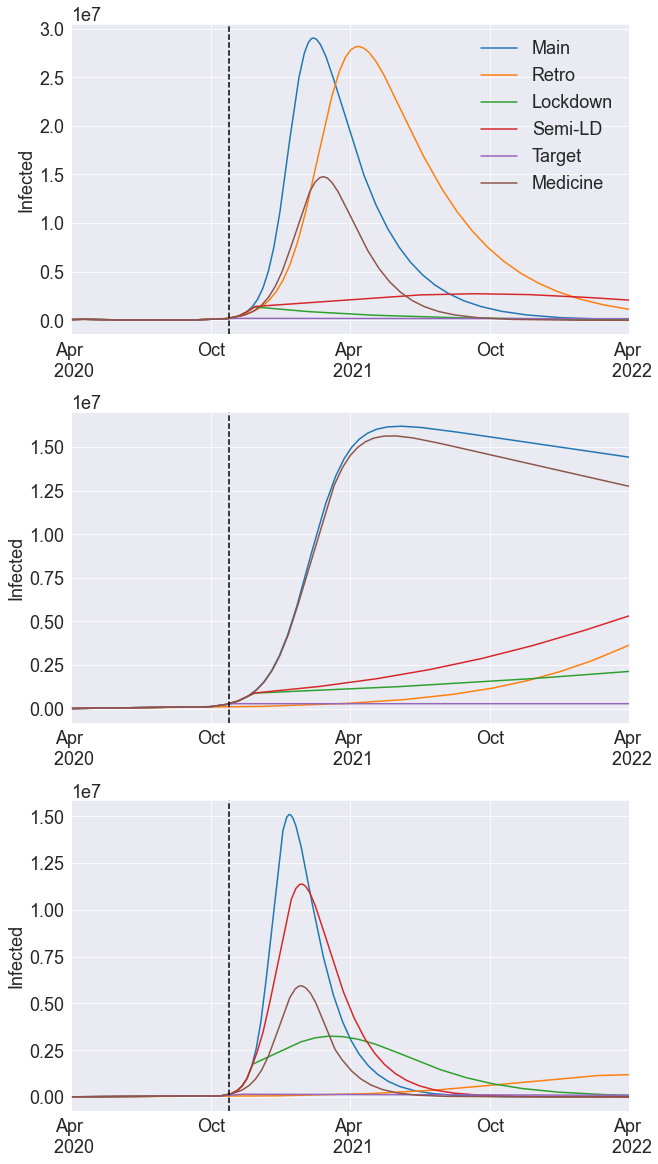

In [35]:
scenarios = ['Main', 'Retro', 'Lockdown', 'Semi-LD','Target','Medicine']
fig, axs = plt.subplots(3, 1, figsize=(10,20), sharex=False)
plt.subplots_adjust(hspace=0.25)
sns.set_style("darkgrid")
dateticks = [datetime.date(2020, 4, 1),datetime.date(2020, 10, 1),
             datetime.date(2021, 4, 1),datetime.date(2021, 10, 1),
             datetime.date(2022, 4, 1)]
datelabels = ['Apr \n 2020','Oct','Apr \n 2021','Oct','Apr \n 2022']


for i in scenarios:
    data = NL.simulate(i,show_figure=False)['Infected']
    axs[1].plot(NL.simulate(i,show_figure=False)['Date'],data,label=i)
    data = IT.simulate(i,show_figure=False)['Infected']
    axs[0].plot(IT.simulate(i,show_figure=False)['Date'],data,label=i)
    data = PL.simulate(i,show_figure=False)['Infected']
    axs[2].plot(PL.simulate(i,show_figure=False)['Date'],data,label=i)

for i in range(3):
    axs[i].set_xlim([datetime.date(2020, 4, 1),datetime.date(2022, 4, 1)])
    axs[i].set_xticks(dateticks)
    axs[i].set_xticklabels(datelabels)
    axs[i].set_ylabel('Infected')
    axs[i].axvline(x=datetime.date.today(),color='k',linestyle='--')

    
axs[0].legend()
plt.rcParams.update({'font.size': 18})


fig.savefig('project_infected.pdf',dpi=100)


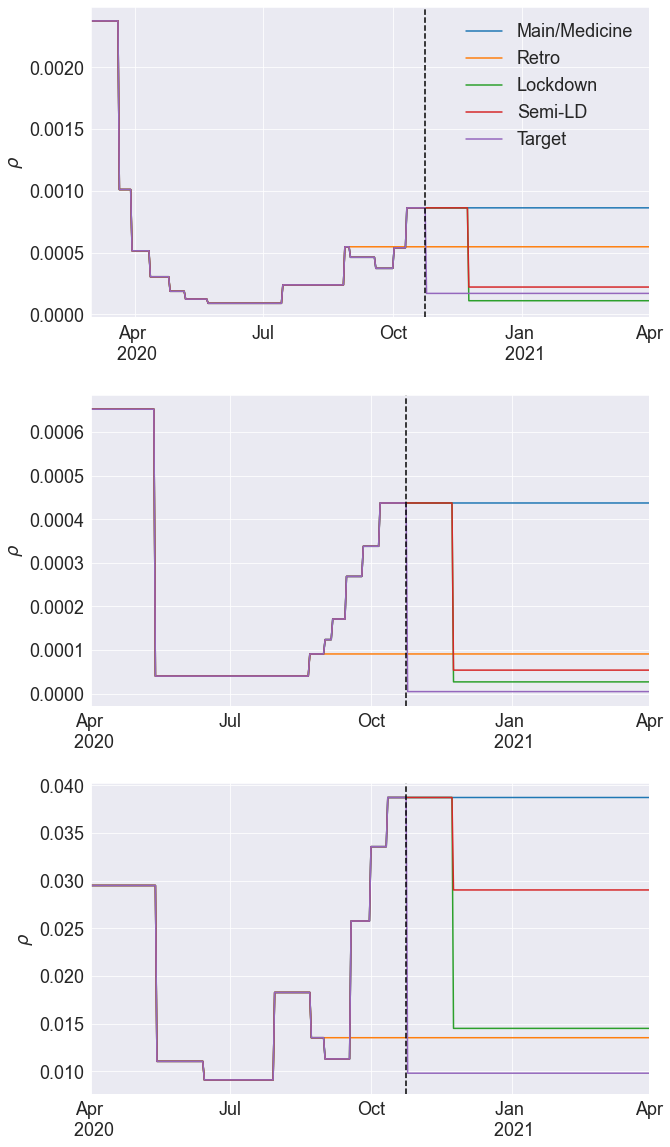

In [34]:
scenarios = ['Main', 'Retro', 'Lockdown', 'Semi-LD','Target']
labels = ['Main/Medicine', 'Retro', 'Lockdown', 'Semi-LD','Target']

fig, axs = plt.subplots(3, 1, figsize=(10,20), sharex=False)
plt.subplots_adjust(hspace=0.25)
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 18})
dateticks = [datetime.date(2020, 4, 1),datetime.date(2020, 7, 1),
             datetime.date(2020, 10, 1),datetime.date(2021, 1, 1),
             datetime.date(2021, 4, 1)]
datelabels = ['Apr \n 2020','Jul','Oct','Jan \n 2021','Apr']
NL_index = NL.history(target='rho',show_figure=False).index
IT_index = IT.history(target='rho',show_figure=False).index
PL_index = PL.history(target='rho',show_figure=False).index

for i in scenarios:
    data = NL.history(target='rho',show_figure=False)[i]
    axs[1].plot(NL_index,data,label=labels[scenarios.index(i)])
    data = IT.history(target='rho',show_figure=False)[i] 
    axs[0].plot(IT_index,data,label=labels[scenarios.index(i)])
    data = PL.history(target='rho',show_figure=False)[i] 
    axs[2].plot(PL_index,data,label=labels[scenarios.index(i)])

for i in range(3):
    axs[i].set_xticks(dateticks)
    axs[i].set_xticklabels(datelabels)
    axs[i].set_ylabel(r'$\rho$')
    axs[i].axvline(x=datetime.date.today(),color='k',linestyle='--')
axs[0].set_xlim([datetime.date(2020, 3, 1),datetime.date(2021, 4, 1)])
axs[1].set_xlim([datetime.date(2020, 4, 1),datetime.date(2021, 4, 1)])
axs[2].set_xlim([datetime.date(2020, 4, 1),datetime.date(2021, 4, 1)])



    
axs[0].legend(fontsize=18,loc='top right')

fig.savefig('project_rho.pdf',dpi=100)
